In [1]:
# Célula 1: Importar todas as bibliotecas necessárias
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
import os
warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Criar pastas se não existirem
os.makedirs('../data', exist_ok=True)
os.makedirs('../visualizations', exist_ok=True)

print("✅ Bibliotecas importadas com sucesso!")
print("📁 Pastas criadas: data/ e visualizations/")

✅ Bibliotecas importadas com sucesso!
📁 Pastas criadas: data/ e visualizations/


In [2]:
# Célula 2: Gerar dados dos sensores - MÍNIMO 500 leituras por sensor
np.random.seed(42)

def gerar_dados_sensores(n_leituras_por_sensor=600):
    """
    Gera dados simulados para sensores DHT22 e LDR
    Total de leituras = n_leituras_por_sensor * 3 sensores
    """
    
    # Timestamps - leituras a cada 10 minutos
    base_time = datetime.now() - timedelta(days=10)
    
    todos_dados = []
    
    # SENSOR 1 - TEMPERATURA (DHT22)
    print("Gerando dados de TEMPERATURA...")
    for i in range(n_leituras_por_sensor):
        timestamp = base_time + timedelta(minutes=10*i)
        hora = timestamp.hour
        
        # Simular variação diária de temperatura
        if 6 <= hora <= 18:  # Dia
            temp_base = 25 + 3 * np.sin((hora - 6) * np.pi / 12)
        else:  # Noite
            temp_base = 20 + np.random.normal(0, 1)
        
        # Adicionar ruído e anomalias ocasionais
        if np.random.random() < 0.05:  # 5% de anomalias
            temperatura = temp_base + np.random.choice([-8, 10])
        else:
            temperatura = temp_base + np.random.normal(0, 1.5)
        
        temperatura = np.clip(temperatura, 10, 40)
        
        todos_dados.append({
            'id_sensor': 1,
            'nome_sensor': 'DHT22_Temp',
            'tipo_medicao': 'temperatura',
            'timestamp': timestamp,
            'valor': round(temperatura, 2),
            'unidade': '°C'
        })
    
    # SENSOR 2 - UMIDADE (DHT22)
    print("Gerando dados de UMIDADE...")
    for i in range(n_leituras_por_sensor):
        timestamp = base_time + timedelta(minutes=10*i)
        hora = timestamp.hour
        
        # Umidade varia inversamente com temperatura
        if 6 <= hora <= 18:
            umid_base = 45 + 10 * np.cos((hora - 6) * np.pi / 12)
        else:
            umid_base = 60 + np.random.normal(0, 5)
        
        # Anomalias
        if np.random.random() < 0.03:
            umidade = umid_base + np.random.choice([-20, 25])
        else:
            umidade = umid_base + np.random.normal(0, 3)
        
        umidade = np.clip(umidade, 20, 90)
        
        todos_dados.append({
            'id_sensor': 2,
            'nome_sensor': 'DHT22_Umid',
            'tipo_medicao': 'umidade',
            'timestamp': timestamp,
            'valor': round(umidade, 2),
            'unidade': '%'
        })
    
    # SENSOR 3 - LUMINOSIDADE (LDR)
    print("Gerando dados de LUMINOSIDADE...")
    for i in range(n_leituras_por_sensor):
        timestamp = base_time + timedelta(minutes=10*i)
        hora = timestamp.hour
        dia_semana = timestamp.weekday()
        
        # Luminosidade segue padrão dia/noite
        if 6 <= hora <= 18:
            # Pico ao meio-dia
            lux_base = 800 * np.sin((hora - 6) * np.pi / 12) + 200
        else:
            lux_base = 50 + np.random.normal(0, 10)
        
        # Fim de semana tem menos luz (fábrica desligada)
        if dia_semana >= 5:  # Sábado e domingo
            lux_base = lux_base * 0.3
        
        # Ruído
        luminosidade = lux_base + np.random.normal(0, 50)
        luminosidade = np.clip(luminosidade, 0, 1000)
        
        todos_dados.append({
            'id_sensor': 3,
            'nome_sensor': 'LDR_01',
            'tipo_medicao': 'luminosidade',
            'timestamp': timestamp,
            'valor': round(luminosidade, 2),
            'unidade': 'lux'
        })
    
    # Criar DataFrame
    df_longo = pd.DataFrame(todos_dados)
    
    # Adicionar estado operacional baseado nos valores
    def classificar_estado(row):
        valor = row['valor']
        tipo = row['tipo_medicao']
        
        if tipo == 'temperatura':
            if valor < 15 or valor > 32:
                return 'critico'
            elif valor < 18 or valor > 28:
                return 'alerta'
            else:
                return 'normal'
        elif tipo == 'umidade':
            if valor < 30 or valor > 75:
                return 'critico'
            elif valor < 35 or valor > 70:
                return 'alerta'
            else:
                return 'normal'
        else:  # luminosidade
            hora = row['timestamp'].hour
            if hora >= 22 or hora <= 5:
                if valor > 200:
                    return 'alerta'
            return 'normal'
    
    df_longo['estado_operacional'] = df_longo.apply(classificar_estado, axis=1)
    
    # Ordenar por timestamp e sensor
    df_longo = df_longo.sort_values(['id_sensor', 'timestamp'])
    
    print(f"\n✅ Dataset gerado com sucesso!")
    print(f"📊 Total de leituras: {len(df_longo)}")
    print(f"📊 Leituras por sensor:")
    print(df_longo.groupby('nome_sensor').size())
    
    return df_longo

# Gerar e salvar dados
df_longo = gerar_dados_sensores(600)  # 600 * 3 = 1800 leituras totais
df_longo.to_csv('../data/dados_sensores_longo.csv', index=False)

# Criar também versão em formato largo para análise
df_pivot = df_longo.pivot_table(
    index='timestamp',
    columns='tipo_medicao',
    values='valor',
    aggfunc='first'
).reset_index()

# Pegar o estado mais comum para cada timestamp
estados = df_longo.groupby('timestamp')['estado_operacional'].agg(lambda x: x.mode()[0])
df_pivot['estado_operacional'] = df_pivot['timestamp'].map(estados)

df_pivot.to_csv('../data/dados_sensores_largo.csv', index=False)

print("\n✅ Arquivos salvos:")
print("   - dados_sensores_longo.csv (formato por leitura)")
print("   - dados_sensores_largo.csv (formato por timestamp)")
print("\n📊 Distribuição dos estados:")
print(df_longo['estado_operacional'].value_counts())

Gerando dados de TEMPERATURA...
Gerando dados de UMIDADE...
Gerando dados de LUMINOSIDADE...

✅ Dataset gerado com sucesso!
📊 Total de leituras: 1800
📊 Leituras por sensor:
nome_sensor
DHT22_Temp    600
DHT22_Umid    600
LDR_01        600
dtype: int64

✅ Arquivos salvos:
   - dados_sensores_longo.csv (formato por leitura)
   - dados_sensores_largo.csv (formato por timestamp)

📊 Distribuição dos estados:
estado_operacional
normal     1607
alerta      161
critico      32
Name: count, dtype: int64


ESTATÍSTICAS POR SENSOR:

DHT22_Temp:
  Min: 10.66
  Max: 37.90
  Média: 23.59
  Desvio: 4.20

DHT22_Umid:
  Min: 20.00
  Max: 83.98
  Média: 52.05
  Desvio: 10.98

LDR_01:
  Min: 0.00
  Max: 1000.00
  Média: 307.30
  Desvio: 340.75


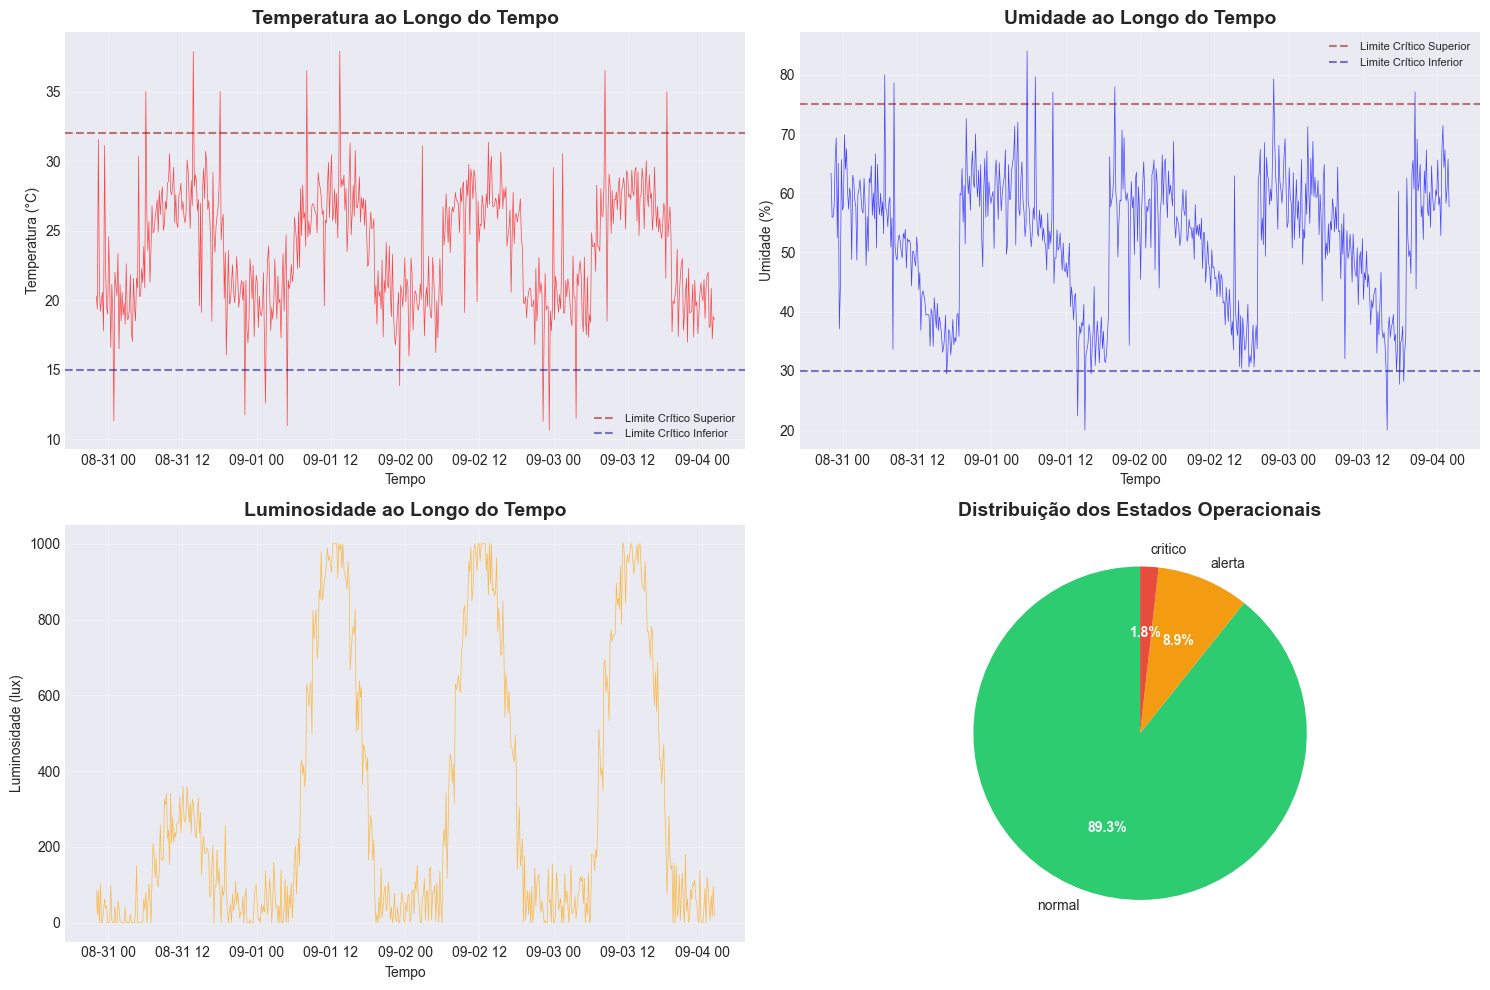


✅ Gráfico salvo em 'visualizations/analise_sensores.png'


In [3]:
# Célula 3: Análise exploratória e visualização dos dados

# Estatísticas por sensor
print("ESTATÍSTICAS POR SENSOR:")
print("=" * 60)
for sensor in df_longo['nome_sensor'].unique():
    dados_sensor = df_longo[df_longo['nome_sensor'] == sensor]['valor']
    print(f"\n{sensor}:")
    print(f"  Min: {dados_sensor.min():.2f}")
    print(f"  Max: {dados_sensor.max():.2f}")
    print(f"  Média: {dados_sensor.mean():.2f}")
    print(f"  Desvio: {dados_sensor.std():.2f}")

# Criar visualizações
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: Temperatura ao longo do tempo
temp_data = df_longo[df_longo['tipo_medicao'] == 'temperatura']
axes[0, 0].plot(temp_data['timestamp'], temp_data['valor'], alpha=0.7, color='red', linewidth=0.5)
axes[0, 0].set_title('Temperatura ao Longo do Tempo', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Tempo')
axes[0, 0].set_ylabel('Temperatura (°C)')
axes[0, 0].axhline(y=32, color='darkred', linestyle='--', alpha=0.5, label='Limite Crítico Superior')
axes[0, 0].axhline(y=15, color='darkblue', linestyle='--', alpha=0.5, label='Limite Crítico Inferior')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(fontsize=8)

# Gráfico 2: Umidade ao longo do tempo
umid_data = df_longo[df_longo['tipo_medicao'] == 'umidade']
axes[0, 1].plot(umid_data['timestamp'], umid_data['valor'], alpha=0.7, color='blue', linewidth=0.5)
axes[0, 1].set_title('Umidade ao Longo do Tempo', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Tempo')
axes[0, 1].set_ylabel('Umidade (%)')
axes[0, 1].axhline(y=75, color='darkred', linestyle='--', alpha=0.5, label='Limite Crítico Superior')
axes[0, 1].axhline(y=30, color='darkblue', linestyle='--', alpha=0.5, label='Limite Crítico Inferior')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(fontsize=8)

# Gráfico 3: Luminosidade ao longo do tempo
lux_data = df_longo[df_longo['tipo_medicao'] == 'luminosidade']
axes[1, 0].plot(lux_data['timestamp'], lux_data['valor'], alpha=0.7, color='orange', linewidth=0.5)
axes[1, 0].set_title('Luminosidade ao Longo do Tempo', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Tempo')
axes[1, 0].set_ylabel('Luminosidade (lux)')
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Distribuição dos Estados Operacionais
estados_count = df_longo['estado_operacional'].value_counts()
colors = {'normal': '#2ecc71', 'alerta': '#f39c12', 'critico': '#e74c3c'}
wedges, texts, autotexts = axes[1, 1].pie(
    estados_count.values,
    labels=estados_count.index,
    autopct='%1.1f%%',
    colors=[colors.get(x, '#333333') for x in estados_count.index],
    startangle=90
)
axes[1, 1].set_title('Distribuição dos Estados Operacionais', fontsize=14, fontweight='bold')

# Melhorar aparência dos percentuais
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.savefig('../visualizations/analise_sensores.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico salvo em 'visualizations/analise_sensores.png'")

In [4]:
# Célula 4: Machine Learning - Treinamento do modelo
print("🤖 INICIANDO MACHINE LEARNING")
print("=" * 60)

# Usar dados em formato largo para ML
df_ml = pd.read_csv('../data/dados_sensores_largo.csv')
df_ml['timestamp'] = pd.to_datetime(df_ml['timestamp'])

# Preparar features
feature_cols = ['temperatura', 'umidade', 'luminosidade']

# Adicionar features temporais
df_ml['hora'] = df_ml['timestamp'].dt.hour
df_ml['dia_semana'] = df_ml['timestamp'].dt.dayofweek

# Features para o modelo
X = df_ml[feature_cols + ['hora', 'dia_semana']].copy()
y = df_ml['estado_operacional']

# Adicionar features engineered
X['temp_umid_ratio'] = X['temperatura'] / (X['umidade'] + 1)
X['is_business_hours'] = ((X['hora'] >= 8) & (X['hora'] <= 18)).astype(int)
X['is_weekend'] = (X['dia_semana'] >= 5).astype(int)
X['temp_squared'] = X['temperatura'] ** 2
X['umid_squared'] = X['umidade'] ** 2

print(f"📊 Shape dos dados: {X.shape}")
print(f"📊 Features utilizadas: {list(X.columns)}")

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\n📊 Tamanho do conjunto de treino: {len(X_train)}")
print(f"📊 Tamanho do conjunto de teste: {len(X_test)}")

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar modelo Random Forest
print("\n⏳ Treinando modelo Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Fazer predições
y_pred = rf_model.predict(X_test_scaled)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ MODELO TREINADO COM SUCESSO!")
print(f"🎯 Acurácia do modelo: {accuracy:.2%}")

print("\n📊 RELATÓRIO DE CLASSIFICAÇÃO:")
print("=" * 60)
print(classification_report(y_test, y_pred))

# Salvar predições
results_df = pd.DataFrame({
    'real': y_test,
    'predito': y_pred,
    'acertou': y_test == y_pred
})
results_df.to_csv('../data/resultados_predicoes.csv', index=False)
print("\n✅ Resultados salvos em 'data/resultados_predicoes.csv'")

🤖 INICIANDO MACHINE LEARNING
📊 Shape dos dados: (600, 10)
📊 Features utilizadas: ['temperatura', 'umidade', 'luminosidade', 'hora', 'dia_semana', 'temp_umid_ratio', 'is_business_hours', 'is_weekend', 'temp_squared', 'umid_squared']

📊 Tamanho do conjunto de treino: 450
📊 Tamanho do conjunto de teste: 150

⏳ Treinando modelo Random Forest...

✅ MODELO TREINADO COM SUCESSO!
🎯 Acurácia do modelo: 98.67%

📊 RELATÓRIO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

      alerta       1.00      0.33      0.50         3
      normal       0.99      1.00      0.99       147

    accuracy                           0.99       150
   macro avg       0.99      0.67      0.75       150
weighted avg       0.99      0.99      0.98       150


✅ Resultados salvos em 'data/resultados_predicoes.csv'


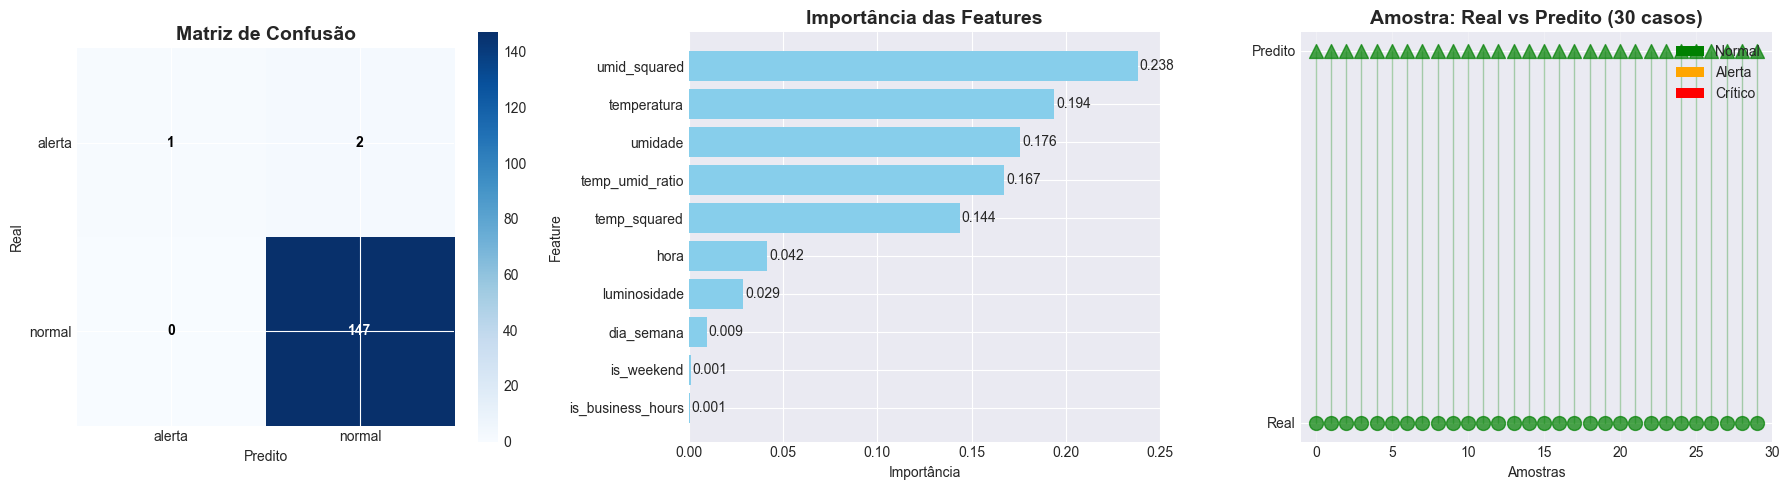

✅ Resultados salvos em 'visualizations/resultados_ml.png'

📊 ESTATÍSTICAS FINAIS:
Total de leituras no dataset longo: 1800
Leituras por sensor:
  - DHT22_Temp: 600 leituras
  - DHT22_Umid: 600 leituras
  - LDR_01: 600 leituras

Acurácia do modelo: 98.67%
Estados preditos:
  - normal: 149 (99.3%)
  - alerta: 1 (0.7%)


In [5]:
# Célula 5: Visualização dos resultados do ML

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())

im = axes[0].imshow(cm, cmap='Blues')
axes[0].set_title('Matriz de Confusão', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Real')
axes[0].set_xticks(range(len(labels)))
axes[0].set_yticks(range(len(labels)))
axes[0].set_xticklabels(labels)
axes[0].set_yticklabels(labels)

# Adicionar valores na matriz
for i in range(len(labels)):
    for j in range(len(labels)):
        text = axes[0].text(j, i, str(cm[i, j]),
                           ha="center", va="center",
                           color="white" if cm[i, j] > cm.max()/2 else "black",
                           fontweight='bold')

plt.colorbar(im, ax=axes[0])

# 2. Importância das Features
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

axes[1].barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
axes[1].set_title('Importância das Features', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Importância')
axes[1].set_ylabel('Feature')

# Adicionar valores nas barras
for i, v in enumerate(feature_importance['importance']):
    axes[1].text(v + 0.001, i, f'{v:.3f}', va='center')

# 3. Comparação Real vs Predito (Amostra de 30 pontos)
sample_size = min(30, len(y_test))
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)
sample_real = y_test.iloc[sample_indices].values
sample_pred = y_pred[sample_indices]

x_positions = np.arange(sample_size)
colors_map = {'normal': 'green', 'alerta': 'orange', 'critico': 'red'}

# Plot real
for i, val in enumerate(sample_real):
    axes[2].scatter(i, 0, c=colors_map.get(val, 'gray'), s=100, marker='o', alpha=0.7)

# Plot predito
for i, val in enumerate(sample_pred):
    axes[2].scatter(i, 1, c=colors_map.get(val, 'gray'), s=100, marker='^', alpha=0.7)

# Linhas conectando real e predito
for i in range(sample_size):
    if sample_real[i] == sample_pred[i]:
        axes[2].plot([i, i], [0, 1], 'g-', alpha=0.3, linewidth=1)
    else:
        axes[2].plot([i, i], [0, 1], 'r-', alpha=0.3, linewidth=1)

axes[2].set_title(f'Amostra: Real vs Predito ({sample_size} casos)', fontsize=14, fontweight='bold')
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(['Real', 'Predito'])
axes[2].set_xlabel('Amostras')
axes[2].set_xlim(-1, sample_size)
axes[2].grid(True, alpha=0.3, axis='x')

# Adicionar legenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Normal'),
    Patch(facecolor='orange', label='Alerta'),
    Patch(facecolor='red', label='Crítico')
]
axes[2].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('../visualizations/resultados_ml.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Resultados salvos em 'visualizations/resultados_ml.png'")

# Estatísticas finais
print("\n📊 ESTATÍSTICAS FINAIS:")
print("=" * 60)
print(f"Total de leituras no dataset longo: {len(df_longo)}")
print(f"Leituras por sensor:")
for sensor in df_longo['nome_sensor'].unique():
    count = len(df_longo[df_longo['nome_sensor'] == sensor])
    print(f"  - {sensor}: {count} leituras")

print(f"\nAcurácia do modelo: {accuracy:.2%}")
print(f"Estados preditos:")
preditos = pd.Series(y_pred).value_counts()
for estado, count in preditos.items():
    print(f"  - {estado}: {count} ({count/len(y_pred)*100:.1f}%)")